In [2]:
# Load mat files
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os

In [361]:
data_paths = glob('data/*.csv')
print(f"Number of stocks {len(data_paths)}")
amzn_data_p = [d for d in data_paths if 'AMZN' in d]
data_paths = [d for d in data_paths if 'AMZN' not in d]
print(f"Number of stocks after removing AMZN {len(data_paths)}")

Number of stocks 27
Number of stocks after removing AMZN 26


In [362]:
id2name = {}
data_arr = []
for i, dpath in enumerate(data_paths):
    name = os.path.basename(dpath).split('.')[0]
    id2name[i] = name

    ds = pd.read_csv(dpath)
    data_arr.append(ds['Close'].values)

data_arr = np.array(data_arr)
print(data_arr.shape)

amzn_ds = pd.read_csv(amzn_data_p[0])
amzn_data = amzn_ds['Close'].values

(26, 2515)


In [365]:
id2name[26] = 'AMZN'
print(id2name)
print(f"Shape of data is {data_arr.shape}")

{0: 'MCHP', 1: 'APH', 2: 'STM', 3: 'ADI', 4: 'IFNNY', 5: 'TSM', 6: 'INTC', 7: 'GLW', 8: 'TXN', 9: 'AMAT', 10: 'AMD', 11: 'KLAC', 12: 'NXPI', 13: 'NVDA', 14: 'MRVL', 15: 'MPWR', 16: 'MRAAY', 17: 'AVGO', 18: 'TEL', 19: 'ON', 20: 'QCOM', 21: 'HXGBY', 22: 'GRMN', 23: 'MU', 24: 'ASML', 25: 'LRCX', 26: 'AMZN'}
Shape of data is (26, 2515)


In [364]:
train_split = 0.9
split_idx = np.int64(data_arr.shape[1] * train_split)
train_data = data_arr[:, :split_idx]
test_data = data_arr[:, split_idx:]
print(f"Shape of training data {train_data.shape}")
print(f"Shape of testing data {test_data.shape}")

amzn_train = amzn_data[:np.int64(len(amzn_data) * train_split)]
amzn_test = amzn_data[np.int64(len(amzn_data) * train_split):]

Shape of training data (26, 2263)
Shape of testing data (26, 252)


#### Estimation metrics

In [6]:
def compute_mse(Y, Y_hat):
    assert Y.shape == Y_hat.shape, f"Shape mismatch {Y.shape}, {Y_hat.shape}"
    return np.mean((Y - Y_hat)**2)

def compute_mae(Y, Y_hat):
    assert Y.shape == Y_hat.shape, f"Shape mismatch {Y.shape}, {Y_hat.shape}"
    return np.mean(np.abs(Y - Y_hat))

## Wolf of Wall Street!

### Strategy

Use a long moving average predictor (~30days) and a kalman filter prediction. Whenever both predictors are above the current value, BUY. Whenever both predictors are below the current value, SELL. 

Short settling: \
Consider the prediction for multi-day ahead. If this prediction shows a drop in price, and if the velocity is negative, perform a short sell in this time window.

In [ ]:
class KalmanFilter():
    def __init__(self, A, H, P_init, X, x_in):
        self.A = A
        self.H = H
        self.P = P_init
        self.x = np.array([[X[0]], [0]])
        self.X = X

        velocity = np.diff(X) # Rate of change of stock price
        velocity = np.hstack(([0], velocity))   # prepend a 0 for initial velocity
        x_in = x_in
        # Estimate R (measurement noise covariance)
        self.R = np.reshape(np.var(x_in), (1,1))
        # Estimate Q (process noise covariance)
        vel_in = velocity[:len(x_in)]
        del_x0 = np.diff(x_in) - vel_in[:-1]    # delta x0 (delta stock price)
        del_x1 = np.diff(vel_in)    # delta x1 (delta velocity)
        self.Q = np.cov(np.vstack((del_x0, del_x1))) * 1e-1

    def predict(self):        
        x_pred = self.A @ self.x    # (2, 2) * (2, 1) --> (2, 1)
        P_pred = self.A @ self.P @ self.A.T + self.Q    # (2,2) + (2,2) --> (2,2)
        return x_pred, P_pred

    def update(self, x_pred, P_pred, z):
        K = (P_pred @ self.H.T) / (self.H @ P_pred @ self.H.T + self.R) # (2,2) * (2,1) / (1,1) --> (2,1)
        self.x = x_pred + K @ (z - self.H @ x_pred)
        self.P = (np.eye(2) - K @ self.H) @ P_pred   # (2,2) * (2,2) --> (2,2)

    def get_state(self):
        return self.x   
    

In [351]:
window = 30
day_shift = 30
all_short_sell_ids = []
all_ypreds = []
all_ypreds30 = []
all_ytrue = []
all_MA40s = []
all_MA5 = []

for stock, (x_in, x_train) in enumerate(zip(train_data, data_arr)):
    velocity = np.diff(x_train)  # Rate of change of stock price
    velocity = np.hstack(([0], velocity))  # Prepend a 0 for initial velocity

    # Initialize Kalman filter parameters
    A = np.array([[1, 1], [0, 1]])    # (2, 2)
    H = np.array([[1, 0]])            # (1, 2)
    P_init = np.eye(2)                # Initial error covariance
    x_init = np.array([[x_train[0]], [0]])  # Initial state with velocity 0

    # Estimate R (measurement noise covariance)
    R = np.reshape(np.var(x_in), (1, 1))
    # Estimate Q (process noise covariance)
    vel_in = velocity[:len(x_in)]
    del_x0 = np.diff(x_in) - vel_in[:-1]
    del_x1 = np.diff(vel_in)
    Q = np.cov(np.vstack((del_x0, del_x1))) * 1e-1

    # Instantiate the Kalman filter
    # kalman_filter = KalmanFilterGPT(A, H, Q, R, x_init, P_init)
    kalman_1day = KalmanFilter(A=A, H=H, P_init=P_init, X=x_train, x_in=x_in)
    kalman_30day = KalmanFilter(A=A, H=H, P_init=P_init, X=x_train, x_in=x_in)

    # Prepare for predictions
    investment_net = 100000
    MA40 = []
    MA5 = []
    BORROW = False
    SHORT_SELLS = 0
    short_sell_ids = []
    N = x_train.shape[0]
    Y_preds = []
    Y_preds30 = []
    Y_true = []

    for i in range(1, N):
        # Compute moving average
        if i > window:
            MA40.append(np.mean(x_train[i - window:i]))
        if i > 5:
            MA5.append(np.mean(x_train[i - 5:i]))

        # Kalman Prediction
        x_pred, P_pred = kalman_1day.predict()
        z = np.array([x_train[i - 1]])  # Current observation
        kalman_1day.update(x_pred, P_pred, z)

        # 30-day ahead prediction
        if i > day_shift:
            x_pred30, P_pred30 = kalman_30day.predict()
            z30 = np.array([x_train[i - day_shift]])  # Current observation
            kalman_30day.update(x_pred30, P_pred30, z30)
            x_est30 = kalman_30day.get_state()
            Y_preds30.append(x_est30[0][0])

        # Store predictions and true values
        x_est1 = kalman_1day.get_state()

        Y_preds.append(x_est1[0][0])
        Y_true.append(x_train[i])

        ################## TRADING STRATEGY ##################
        if i == split_idx:
            print(f"######### Trading Begins for {id2name[stock]}!! #########")
        if i > split_idx:
            # Check for short selling
            if BORROW and (i - short_window == day_shift):
                investment_net = investment_net - z
                BORROW = False
                short_window = 0 # NOT needed here, but for clarity
                SHORT_SELLS += 1
            if not BORROW and (i > 30) and (x_est1[1][0] < -0.5) and (x_est30[0][0] - x_train[i] < 5) and (investment_net > 0):
                # print(f"Performing borrow for short sell")
                investment_net = investment_net + z
                BORROW = True
                short_window = i
                short_sell_ids.append(i)
            # Buy if x > z and MA40 > z
            if x_est1[0][0] - z > 2 and MA40[-1] - z > 2 and investment_net > 0:
                investment_net = (investment_net - z)[0]
            elif x_est1[0][0] - z < 2 and MA40[-1] - z < 2:
                investment_net = (investment_net + z)[0]

        ################# TRADING STRATEGY END ##################
    all_short_sell_ids.append(short_sell_ids)
    all_MA40s.append(MA40)
    all_MA5.append(MA5)
    all_ypreds.append(Y_preds)
    all_ypreds30.append(Y_preds30)
    all_ytrue.append(Y_true)

    print(f"Final investment: ${np.round(investment_net, 3)}")
    print(f"# Short sells: {SHORT_SELLS}")

######### Trading Begins for MCHP!! #########
Final investment: $110279.13
# Short sells: 2
######### Trading Begins for APH!! #########
Final investment: $115017.55
# Short sells: 0
######### Trading Begins for STM!! #########
Final investment: $107470.68
# Short sells: 0
######### Trading Begins for ADI!! #########
Final investment: $114935.81
# Short sells: 1
######### Trading Begins for IFNNY!! #########
Final investment: $107232.03
# Short sells: 0
######### Trading Begins for TSM!! #########
Final investment: $108367.38
# Short sells: 0
######### Trading Begins for INTC!! #########
Final investment: $107216.22
# Short sells: 0
######### Trading Begins for GLW!! #########
Final investment: $107454.92
# Short sells: 0
######### Trading Begins for TXN!! #########
Final investment: $110737.48
# Short sells: 1
######### Trading Begins for AMAT!! #########
Final investment: $112266.98
# Short sells: 2
######### Trading Begins for AMD!! #########
Final investment: $107820.87
# Short sel

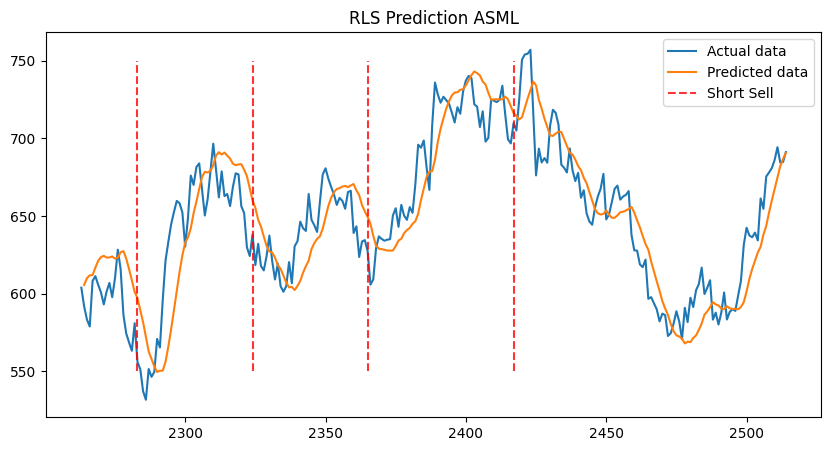

In [360]:
stock = 24
test_idx = train_data.shape[1]
test_x = np.arange(test_idx + 1, data_arr.shape[1])
train_start = test_idx
train_x = np.arange(train_start, data_arr.shape[1])
plt.figure(figsize=(10, 5))
plt.plot(train_x, data_arr[stock, train_start:], label="Actual data")
plt.plot(test_x, all_ypreds[stock][test_idx:], label="Predicted data")
plt.vlines(all_short_sell_ids[stock], ymin=550, ymax=750, color='r', label='Short Sell', alpha=0.8, linestyles='dashed')
plt.title(f"RLS Prediction {id2name[stock]}")
plt.legend()

### Stock trading for Amazon

In [366]:

stock = 26
x_in, x_train = amzn_train, amzn_data
velocity = np.diff(x_train)  # Rate of change of stock price
velocity = np.hstack(([0], velocity))  # Prepend a 0 for initial velocity

# Initialize Kalman filter parameters
A = np.array([[1, 1], [0, 1]])    # (2, 2)
H = np.array([[1, 0]])            # (1, 2)
P_init = np.eye(2)                # Initial error covariance
x_init = np.array([[x_train[0]], [0]])  # Initial state with velocity 0

# Estimate R (measurement noise covariance)
R = np.reshape(np.var(x_in), (1, 1))
# Estimate Q (process noise covariance)
vel_in = velocity[:len(x_in)]
del_x0 = np.diff(x_in) - vel_in[:-1]
del_x1 = np.diff(vel_in)
Q = np.cov(np.vstack((del_x0, del_x1))) * 1e-1

# Instantiate the Kalman filter
# kalman_filter = KalmanFilterGPT(A, H, Q, R, x_init, P_init)
kalman_1day = KalmanFilter(A=A, H=H, P_init=P_init, X=x_train, x_in=x_in)
kalman_30day = KalmanFilter(A=A, H=H, P_init=P_init, X=x_train, x_in=x_in)

# Prepare for predictions
investment_net = 100000
MA40 = []
MA5 = []
BORROW = False
SHORT_SELLS = 0
short_sell_ids = []
N = x_train.shape[0]
Y_preds = []
Y_preds30 = []
Y_true = []

for i in range(1, N):
    # Compute moving average
    if i > window:
        MA40.append(np.mean(x_train[i - window:i]))
    if i > 5:
        MA5.append(np.mean(x_train[i - 5:i]))

    # Kalman Prediction
    x_pred, P_pred = kalman_1day.predict()
    z = np.array([x_train[i - 1]])  # Current observation
    kalman_1day.update(x_pred, P_pred, z)

    # 30-day ahead prediction
    if i > day_shift:
        x_pred30, P_pred30 = kalman_30day.predict()
        z30 = np.array([x_train[i - day_shift]])  # Current observation
        kalman_30day.update(x_pred30, P_pred30, z30)
        x_est30 = kalman_30day.get_state()
        Y_preds30.append(x_est30[0][0])

    # Store predictions and true values
    x_est1 = kalman_1day.get_state()

    Y_preds.append(x_est1[0][0])
    Y_true.append(x_train[i])

    ################## TRADING STRATEGY ##################
    if i == split_idx:
        print(f"######### Trading Begins for {id2name[stock]}!! #########")
    if i > split_idx:
        # Check for short selling
        if BORROW and (i - short_window == day_shift):
            investment_net = investment_net - z
            BORROW = False
            short_window = 0 # NOT needed here, but for clarity
            SHORT_SELLS += 1
        if not BORROW and (i > 30) and (x_est1[1][0] < -0.5) and (x_est30[0][0] - x_train[i] < 5) and (investment_net > 0):
            # print(f"Performing borrow for short sell")
            investment_net = investment_net + z
            BORROW = True
            short_window = i
            short_sell_ids.append(i)
        # Buy if x > z and MA40 > z
        if x_est1[0][0] - z > 2 and MA40[-1] - z > 2 and investment_net > 0:
            investment_net = (investment_net - z)[0]
        elif x_est1[0][0] - z < 2 and MA40[-1] - z < 2:
            investment_net = (investment_net + z)[0]

    ################# TRADING STRATEGY END ##################
all_short_sell_ids.append(short_sell_ids)
all_MA40s.append(MA40)
all_MA5.append(MA5)
all_ypreds.append(Y_preds)
all_ypreds30.append(Y_preds30)
all_ytrue.append(Y_true)

print(f"Final investment: ${np.round(investment_net, 3)}")
print(f"# Short sells: {SHORT_SELLS}")

######### Trading Begins for LRCX!! #########
Final investment: $94869988.776
# Short sells: 0
